# Tuning Analysis

## Config Steps

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
!pip install ViennaRNA
!pip install biopython
!pip install scikeras

In [24]:
import os
from Bio import SeqIO
import RNA
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from gensim.models import Word2Vec, KeyedVectors
import pickle
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import time
import seaborn as sns
import pandas as pd
import random
from collections import Counter
from sklearn.model_selection import ParameterGrid
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow.keras.utils import to_categorical

In [25]:
# Load arrays
path = "/content/drive/MyDrive/maestria/tesis"
X_train = np.load(f"{path}/X_train.npy")
X_test = np.load(f"{path}/X_test.npy")
y_train = np.load(f"{path}/y_train.npy")
y_test = np.load(f"{path}/y_test.npy")
sequence_for_screening = str(np.load(f"{path}/sequence_for_screening.npy"))
sequence_for_screening_only_negatives = str(np.load(f"{path}/sequence_for_screening_only_negatives.npy"))
chromosome_path = f"{path}/chromosome1.fa"
invalid_data_path = f"{path}/invalid_data.fa"
chr_with_mirna = f"{path}/chr1_with_mirna.fa"
neg_seq_chr1_1_path = f"{path}/negative_sequence_1.fa"

## Methods

In [26]:
def get_complementary_sequence(sequences):
    complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}
    return [''.join(complement[base] for base in seq) for seq in sequences]
def convert_RNA_sequence_to_DNA(sequence):
    return sequence.replace('U', 'T')

def convert_DNA_sequence_to_RNA(sequence):
    return sequence.replace('T', 'U')

    # Función para crear el modelo Keras
def create_model(neurons=64, activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(Dense(neurons, input_dim=X_train_mirna2vec.shape[1], activation=activation))
    model.add(Dense(1, activation='sigmoid'))  # Para clasificación binaria
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

## FastaManager

In [27]:
class FastaManager:
    FASTA = "fasta"
    FA = "fa"

    @staticmethod
    def read_fasta(file_path):
        """Read sequences from a FASTA file."""
        sequences = []
        with open(file_path, "r") as file:
            for record in SeqIO.parse(file, FastaManager.FASTA):
                sequences.append(str(record.seq))
        return sequences

    @staticmethod
    def get_all_sequences(input_dir):
        """Read FASTA files from input_dir and return sequences."""
        all_sequences = []
        for file_name in os.listdir(input_dir):
            if file_name.endswith(f".{FastaManager.FASTA}") or file_name.endswith(f".{FastaManager.FA}"):
                file_path = os.path.join(input_dir, file_name)
                sequences = FastaManager.read_fasta(file_path)
                all_sequences.extend(sequences)
        return all_sequences

    @staticmethod
    def create_fasta_dataset(input_dir, embedding):
        """Read FASTA files from input_dir and return tokenized sequences."""
        return embedding.tokenize_sequences(FastaManager.get_all_sequences(input_dir))

    @staticmethod
    def create_dataset(sequences, embedding):
        """Read list of sequences and return tokenized sequences."""
        return embedding.tokenize_sequences(sequences)

## Generate Dataset

### Positive Samples

In [28]:
df = pd.read_csv(f'{path}/dataset_DNA_chr1.csv')
df.head()

,pos_inicial,pos_final,secuencia,chromosome
0,65058434,65058508,TGCCATCCTTCAGTTATCACAGTACTGTACCTTTAGAATAGACAGC...,chr1
1,207802443,207802523,CTCCTAAAACACTGATTTCAAATGGTGCTAGATACAAAGATGGAAA...,chr1
2,109598893,109598967,GGCTGTGCCGGGTAGAGAGGGCAGTGGGAGGTAAGAGCTCTTCACC...,chr1
3,9151668,9151777,GGGCCCCACAACGTGCAGCACTTCTAGGGCAGTATACTTGCTGATT...,chr1
4,198858873,198858982,AAGCGGGGCCACAGTTGCATTCATTGTTCAGTGAGCTTGTCCACAC...,chr1


In [29]:
df = df.loc[~df['secuencia'].str.contains('N')]
df

,pos_inicial,pos_final,secuencia,chromosome
0,65058434,65058508,TGCCATCCTTCAGTTATCACAGTACTGTACCTTTAGAATAGACAGC...,chr1
1,207802443,207802523,CTCCTAAAACACTGATTTCAAATGGTGCTAGATACAAAGATGGAAA...,chr1
2,109598893,109598967,GGCTGTGCCGGGTAGAGAGGGCAGTGGGAGGTAAGAGCTCTTCACC...,chr1
3,9151668,9151777,GGGCCCCACAACGTGCAGCACTTCTAGGGCAGTATACTTGCTGATT...,chr1
4,198858873,198858982,AAGCGGGGCCACAGTTGCATTCATTGTTCAGTGAGCTTGTCCACAC...,chr1
...,...,...,...,...
500,102539644,102539726,GAGGCCTGTGTGCCTGTCAAATAGCTACAGTTAAGAAATCTTCACA...,NaN
501,26908642,26908725,TCCAACTCCCAGCTCAAGTGATCCTCCCACTTCAGCCTCTCGAGTG...,NaN
502,54878113,54878193,GCAAAAGGCGTCCTTGGGAATTCAACTGAGTACTAATCGGTAAATA...,NaN
503,47760995,47761104,CCTCCACATGCTTTCAATCCCATGGCAGCCTGTGGGTCCTGGGAAG...,NaN


In [30]:
df = df.drop_duplicates(subset='secuencia')
df

,pos_inicial,pos_final,secuencia,chromosome
0,65058434,65058508,TGCCATCCTTCAGTTATCACAGTACTGTACCTTTAGAATAGACAGC...,chr1
1,207802443,207802523,CTCCTAAAACACTGATTTCAAATGGTGCTAGATACAAAGATGGAAA...,chr1
2,109598893,109598967,GGCTGTGCCGGGTAGAGAGGGCAGTGGGAGGTAAGAGCTCTTCACC...,chr1
3,9151668,9151777,GGGCCCCACAACGTGCAGCACTTCTAGGGCAGTATACTTGCTGATT...,chr1
4,198858873,198858982,AAGCGGGGCCACAGTTGCATTCATTGTTCAGTGAGCTTGTCCACAC...,chr1
...,...,...,...,...
500,102539644,102539726,GAGGCCTGTGTGCCTGTCAAATAGCTACAGTTAAGAAATCTTCACA...,NaN
501,26908642,26908725,TCCAACTCCCAGCTCAAGTGATCCTCCCACTTCAGCCTCTCGAGTG...,NaN
502,54878113,54878193,GCAAAAGGCGTCCTTGGGAATTCAACTGAGTACTAATCGGTAAATA...,NaN
503,47760995,47761104,CCTCCACATGCTTTCAATCCCATGGCAGCCTGTGGGTCCTGGGAAG...,NaN


In [31]:
df['secuencia'] = df['secuencia'].str.replace('\n', '')
positive_sequences = df['secuencia'].to_list()

<ipython-input-31-5415f45b2c93>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['secuencia'] = df['secuencia'].str.replace('\n', '')


In [32]:
positive_sequences.extend([s[::-1] for s in positive_sequences])

In [33]:
positive_sequences.extend(get_complementary_sequence(positive_sequences))

In [34]:
len(positive_sequences)

1992

### Negative Samples

#### Ivani

In [35]:
negative_sequences_ivani = []
negative_sequences_ivani = FastaManager.read_fasta(f"{path}/pseudo_hairpin_human.fasta")[:1992]
negative_sequences_ivani = [convert_RNA_sequence_to_DNA(seq) for seq in negative_sequences_ivani]
len(negative_sequences_ivani)

1992

#### Ensemble

In [36]:
negative_sequences_ensemble = []
negative_sequence_ensemble = FastaManager.read_fasta(neg_seq_chr1_1_path)[0][:10000]
substring_length = 100
substrings = []
for idx in range(0, len(negative_sequence_ensemble)-substring_length, int(substring_length / 19)):
        new_sequence = negative_sequence_ensemble[idx:idx+substring_length]
        substrings.append(new_sequence)
negative_sequences_ensemble.extend(substrings)
len(negative_sequences_ensemble)

1980

#### Hybrid

In [37]:
negative_sequences_hybrid = []
negative_sequences_hybrid.extend(negative_sequences_ivani[:len(negative_sequences_ivani) // 2])
negative_sequences_hybrid.extend(negative_sequences_ensemble[:len(negative_sequences_ensemble) // 2])
len(negative_sequences_hybrid)

1986

## MiRNA2Vec

In [38]:
class MiRNA2Vec:
    def __init__(self, k_mers: int = 3, vector_size: int = 100, epochs: int = 5):
        self.__model = None
        self.k_mers = k_mers
        self.vector_size = vector_size
        self.epochs = epochs
        self.window = 5
        self.min_count = 1
        self.workers = 4
        self.skip_gram = 1

    @property
    def model(self):
        return self.__model

    def __get_tokens(self, sequence):
        return [sequence[i:i + self.k_mers] for i in range(len(sequence) - self.k_mers + 1)]

    def tokenize_sequences(self, sequences):
        """Tokenize sequences into k-mers."""
        tokenized_sequences = []
        for seq in sequences:
            tokens = self.__get_tokens(seq)
            tokenized_sequences.append(tokens)
        return tokenized_sequences

    def train_word2vec(self, tokenized_sequences):
        """Train Word2Vec model on tokenized sequences."""
        self.__model = Word2Vec(sentences=tokenized_sequences,
                                vector_size=self.vector_size,
                                window=self.window,
                                min_count=self.min_count,
                                workers=self.workers,
                                epochs=self.epochs,
                                sg=self.skip_gram)
        return self.__model

    def get_average_embeddings(self, sequences):
        """Get average embedding for each sequence."""
        embeddings = []
        for seq in sequences:
            tokens = self.__get_tokens(seq)
            token_embeddings = [self.model.wv[token] for token in tokens if token in self.model.wv]
            if token_embeddings:
                avg_embedding = np.mean(token_embeddings, axis=0)
            else:
                avg_embedding = np.zeros(self.model.vector_size)
            embeddings.append(avg_embedding.tolist())
        return np.array(embeddings)

    def load_model(self, path, tokenized_sequences):
        self.__model = Word2Vec(sentences=tokenized_sequences,
                                vector_size=self.vector_size,
                                window=self.window,
                                min_count=self.min_count,
                                workers=self.workers,
                                epochs=self.epochs)
        self.__model.wv = KeyedVectors.load_word2vec_format(path,
                                          binary=False)  # Change binary to False if the model is in text format
        # Continue training the Word2Vec model with your new sequences
        self.__model.build_vocab(tokenized_sequences, update=True)  # Update the vocabulary with new sentences
        self.__model.train(tokenized_sequences, total_examples=self.__model.corpus_count, epochs=self.__model.epochs)
        return self.__model


## Tuning

In [41]:
# Create miRNA2Vec instance
miRNA2Vec = MiRNA2Vec(k_mers=5, vector_size=32, epochs=3)
# Create the dataset for Word2Vec
tokenized_sequences = FastaManager.create_dataset(X_train, miRNA2Vec)

# Train the Word2Vec model
miRNA2Vec.train_word2vec(tokenized_sequences)
# Get embeddings for sequences
X_train_mirna2vec = miRNA2Vec.get_average_embeddings(X_train)
X_test_mirna2vec = miRNA2Vec.get_average_embeddings(X_test)

y_positive = np.ones(len(positive_sequences))
y_negative = np.zeros(len(negative_sequences_ensemble))

X = positive_sequences + negative_sequences_ensemble
y = np.append(y_positive, y_negative)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

#### NN

In [ ]:


# Definir el rango de hiperparámetros a probar
param_grid = {
    'neurons': [32, 64, 128],              # Número de neuronas en la capa oculta
    'activation': ['relu', 'tanh'],        # Función de activación
    'optimizer': ['adam', 'sgd'],          # Optimizador
    'batch_size': [32, 64],                # Tamaño del batch
    'epochs': [20, 50]                     # Número de épocas
}



# Escalar los datos de entrada
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_mirna2vec)
X_test_scaled = scaler.transform(X_test_mirna2vec)

# Convertir etiquetas a formato categórico (si es necesario)
# y_train_categorical = to_categorical(y_train)  # No es necesario para clasificación binaria
y_train = np.array(y_train)
y_test = np.array(y_test)

best_score = -np.inf
best_params = None

# Probar cada combinación de hiperparámetros
for params in ParameterGrid(param_grid):
    print(f"Probando con hiperparámetros: {params}")

    # Crear el modelo con los hiperparámetros actuales
    model = KerasClassifier(build_fn=create_model,
                            neurons=params['neurons'],
                            activation=params['activation'],
                            optimizer=params['optimizer'],
                            epochs=params['epochs'],
                            batch_size=params['batch_size'],
                            verbose=0)

    # Entrenar el modelo
    model.fit(X_train_scaled, y_train)

    # Predecir y evaluar
    y_pred = (model.predict_proba(X_test_scaled)[1] > 0.6).astype("int32")

    # Evaluar el modelo
    score = f1_score(y_test, y_pred)

    print(f"Score: {score}")

    # Si es mejor que el anterior, guarda los mejores parámetros
    if score > best_score:
        best_score = score
        best_params = params

print(f"Mejores hiperparámetros: {best_params} con un score de {best_score}")


Probando con hiperparámetros: {'activation': 'relu', 'batch_size': 32, 'epochs': 20, 'neurons': 32, 'optimizer': 'adam'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.877600455970362
Probando con hiperparámetros: {'activation': 'relu', 'batch_size': 32, 'epochs': 20, 'neurons': 32, 'optimizer': 'sgd'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.8707848837209302
Probando con hiperparámetros: {'activation': 'relu', 'batch_size': 32, 'epochs': 20, 'neurons': 64, 'optimizer': 'adam'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.8945051824506602
Probando con hiperparámetros: {'activation': 'relu', 'batch_size': 32, 'epochs': 20, 'neurons': 64, 'optimizer': 'sgd'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.9005147006980188
Probando con hiperparámetros: {'activation': 'relu', 'batch_size': 32, 'epochs': 20, 'neurons': 128, 'optimizer': 'adam'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.9216635806865119
Probando con hiperparámetros: {'activation': 'relu', 'batch_size': 32, 'epochs': 20, 'neurons': 128, 'optimizer': 'sgd'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.9141457793143186
Probando con hiperparámetros: {'activation': 'relu', 'batch_size': 32, 'epochs': 50, 'neurons': 32, 'optimizer': 'adam'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.8904379664835939
Probando con hiperparámetros: {'activation': 'relu', 'batch_size': 32, 'epochs': 50, 'neurons': 32, 'optimizer': 'sgd'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.8836945743023091
Probando con hiperparámetros: {'activation': 'relu', 'batch_size': 32, 'epochs': 50, 'neurons': 64, 'optimizer': 'adam'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.9227747773023778
Probando con hiperparámetros: {'activation': 'relu', 'batch_size': 32, 'epochs': 50, 'neurons': 64, 'optimizer': 'sgd'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.919928335170893
Probando con hiperparámetros: {'activation': 'relu', 'batch_size': 32, 'epochs': 50, 'neurons': 128, 'optimizer': 'adam'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.959139179970462
Probando con hiperparámetros: {'activation': 'relu', 'batch_size': 32, 'epochs': 50, 'neurons': 128, 'optimizer': 'sgd'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.9639916259595255
Probando con hiperparámetros: {'activation': 'relu', 'batch_size': 64, 'epochs': 20, 'neurons': 32, 'optimizer': 'adam'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.8747418642740156
Probando con hiperparámetros: {'activation': 'relu', 'batch_size': 64, 'epochs': 20, 'neurons': 32, 'optimizer': 'sgd'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.8670536802121408
Probando con hiperparámetros: {'activation': 'relu', 'batch_size': 64, 'epochs': 20, 'neurons': 64, 'optimizer': 'adam'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.8828619210354105
Probando con hiperparámetros: {'activation': 'relu', 'batch_size': 64, 'epochs': 20, 'neurons': 64, 'optimizer': 'sgd'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.8848276356339139
Probando con hiperparámetros: {'activation': 'relu', 'batch_size': 64, 'epochs': 20, 'neurons': 128, 'optimizer': 'adam'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.9114155251141552
Probando con hiperparámetros: {'activation': 'relu', 'batch_size': 64, 'epochs': 20, 'neurons': 128, 'optimizer': 'sgd'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.9087651401132373
Probando con hiperparámetros: {'activation': 'relu', 'batch_size': 64, 'epochs': 50, 'neurons': 32, 'optimizer': 'adam'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.8858511837655016
Probando con hiperparámetros: {'activation': 'relu', 'batch_size': 64, 'epochs': 50, 'neurons': 32, 'optimizer': 'sgd'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.8903462379239828
Probando con hiperparámetros: {'activation': 'relu', 'batch_size': 64, 'epochs': 50, 'neurons': 64, 'optimizer': 'adam'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.9145395571851643
Probando con hiperparámetros: {'activation': 'relu', 'batch_size': 64, 'epochs': 50, 'neurons': 64, 'optimizer': 'sgd'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.91600790513834
Probando con hiperparámetros: {'activation': 'relu', 'batch_size': 64, 'epochs': 50, 'neurons': 128, 'optimizer': 'adam'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.9497421794431076
Probando con hiperparámetros: {'activation': 'relu', 'batch_size': 64, 'epochs': 50, 'neurons': 128, 'optimizer': 'sgd'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.9529403538214111
Probando con hiperparámetros: {'activation': 'tanh', 'batch_size': 32, 'epochs': 20, 'neurons': 32, 'optimizer': 'adam'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.8737919272313814
Probando con hiperparámetros: {'activation': 'tanh', 'batch_size': 32, 'epochs': 20, 'neurons': 32, 'optimizer': 'sgd'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.8724103443349049
Probando con hiperparámetros: {'activation': 'tanh', 'batch_size': 32, 'epochs': 20, 'neurons': 64, 'optimizer': 'adam'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.9144944846483524
Probando con hiperparámetros: {'activation': 'tanh', 'batch_size': 32, 'epochs': 20, 'neurons': 64, 'optimizer': 'sgd'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.9147384658533165
Probando con hiperparámetros: {'activation': 'tanh', 'batch_size': 32, 'epochs': 20, 'neurons': 128, 'optimizer': 'adam'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.9390312588003379
Probando con hiperparámetros: {'activation': 'tanh', 'batch_size': 32, 'epochs': 20, 'neurons': 128, 'optimizer': 'sgd'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.9394258440373412
Probando con hiperparámetros: {'activation': 'tanh', 'batch_size': 32, 'epochs': 50, 'neurons': 32, 'optimizer': 'adam'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.8915544332210998
Probando con hiperparámetros: {'activation': 'tanh', 'batch_size': 32, 'epochs': 50, 'neurons': 32, 'optimizer': 'sgd'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.8969569779643232
Probando con hiperparámetros: {'activation': 'tanh', 'batch_size': 32, 'epochs': 50, 'neurons': 64, 'optimizer': 'adam'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.9454289732770745
Probando con hiperparámetros: {'activation': 'tanh', 'batch_size': 32, 'epochs': 50, 'neurons': 64, 'optimizer': 'sgd'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.950076484494507
Probando con hiperparámetros: {'activation': 'tanh', 'batch_size': 32, 'epochs': 50, 'neurons': 128, 'optimizer': 'adam'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.9861189007291082
Probando con hiperparámetros: {'activation': 'tanh', 'batch_size': 32, 'epochs': 50, 'neurons': 128, 'optimizer': 'sgd'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.9866030721750719
Probando con hiperparámetros: {'activation': 'tanh', 'batch_size': 64, 'epochs': 20, 'neurons': 32, 'optimizer': 'adam'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.8667143879742305
Probando con hiperparámetros: {'activation': 'tanh', 'batch_size': 64, 'epochs': 20, 'neurons': 32, 'optimizer': 'sgd'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.8715083798882681
Probando con hiperparámetros: {'activation': 'tanh', 'batch_size': 64, 'epochs': 20, 'neurons': 64, 'optimizer': 'adam'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.8929794520547946
Probando con hiperparámetros: {'activation': 'tanh', 'batch_size': 64, 'epochs': 20, 'neurons': 64, 'optimizer': 'sgd'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.8986274646415383
Probando con hiperparámetros: {'activation': 'tanh', 'batch_size': 64, 'epochs': 20, 'neurons': 128, 'optimizer': 'adam'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.9226405729277458
Probando con hiperparámetros: {'activation': 'tanh', 'batch_size': 64, 'epochs': 20, 'neurons': 128, 'optimizer': 'sgd'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.9223853339889022
Probando con hiperparámetros: {'activation': 'tanh', 'batch_size': 64, 'epochs': 50, 'neurons': 32, 'optimizer': 'adam'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.8877066042420373
Probando con hiperparámetros: {'activation': 'tanh', 'batch_size': 64, 'epochs': 50, 'neurons': 32, 'optimizer': 'sgd'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.8971740346950196
Probando con hiperparámetros: {'activation': 'tanh', 'batch_size': 64, 'epochs': 50, 'neurons': 64, 'optimizer': 'adam'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.9389894472010623
Probando con hiperparámetros: {'activation': 'tanh', 'batch_size': 64, 'epochs': 50, 'neurons': 64, 'optimizer': 'sgd'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.9428172942817294
Probando con hiperparámetros: {'activation': 'tanh', 'batch_size': 64, 'epochs': 50, 'neurons': 128, 'optimizer': 'adam'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.9755554007939271
Probando con hiperparámetros: {'activation': 'tanh', 'batch_size': 64, 'epochs': 50, 'neurons': 128, 'optimizer': 'sgd'}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.9807678858661445
Mejores hiperparámetros: {'activation': 'tanh', 'batch_size': 32, 'epochs': 50, 'neurons': 128, 'optimizer': 'sgd'} con un score de 0.9866030721750719


### miRNA

In [ ]:
# Supón que tienes una función para evaluar el modelo (defínela según tu necesidad).
def evaluate_model(miRNA2Vec):
    X_train_mirna2vec = miRNA2Vec.get_average_embeddings(X_train)
    X_test_mirna2vec = miRNA2Vec.get_average_embeddings(X_test)
    # Escalar los datos de entrada
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_mirna2vec)
    X_test_scaled = scaler.transform(X_test_mirna2vec)

    #y_train = np.array(y_train)
    #y_test = np.array(y_test)

    # Train SVM
    nn_model = KerasClassifier(build_fn=create_model,
                            neurons=128,
                            activation='tanh',
                            optimizer='sgd',
                            epochs=50,
                            batch_size=32,
                            verbose=0)
    nn_model.fit(X_train_mirna2vec, y_train)
    # Predict and evaluate
    y_pred = (np.array([ele[1] for ele in nn_model.predict_proba(X_test_scaled)]) > 0.7).astype("int32")
    return f1_score(y_test, y_pred)

# Definir el rango de hiperparámetros a probar
param_grid = {
    'k_mers': [3, 4, 5],
    'vector_size': [32],
    'epochs': [5, 10, 50]
}

# Proceso de búsqueda de hiperparámetros
best_score = -np.inf
best_params = None

for params in ParameterGrid(param_grid):
    print(f"Probando con hiperparámetros: {params}")
    miRNA2Vec = MiRNA2Vec(k_mers=params['k_mers'], vector_size=params['vector_size'], epochs=params['epochs'])
    tokenized_sequences = FastaManager.create_dataset(X_train, miRNA2Vec)
    miRNA2Vec.train_word2vec(tokenized_sequences)

    # Evalúa el modelo
    score = evaluate_model(miRNA2Vec)

    print(f"Score: {score}")

    # Si es mejor que el anterior, guarda los mejores parámetros
    if score > best_score:
        best_score = score
        best_params = params

print(f"Mejores hiperparámetros: {best_params} con un score de {best_score}")

# Entrena el mejor modelo con los mejores hiperparámetros
best_miRNA2Vec = MiRNA2Vec(k_mers=best_params['k_mers'], vector_size=best_params['vector_size'], epochs=best_params['epochs'])
best_miRNA2Vec.train_word2vec(tokenized_sequences)

Probando con hiperparámetros: {'epochs': 5, 'k_mers': 3, 'vector_size': 32}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.6934097421203438
Probando con hiperparámetros: {'epochs': 5, 'k_mers': 4, 'vector_size': 32}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.7211267605633803
Probando con hiperparámetros: {'epochs': 5, 'k_mers': 5, 'vector_size': 32}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.7203065134099617
Probando con hiperparámetros: {'epochs': 10, 'k_mers': 3, 'vector_size': 32}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.6770981507823614
Probando con hiperparámetros: {'epochs': 10, 'k_mers': 4, 'vector_size': 32}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.7208976157082749
Probando con hiperparámetros: {'epochs': 10, 'k_mers': 5, 'vector_size': 32}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.7324675324675325
Probando con hiperparámetros: {'epochs': 50, 'k_mers': 3, 'vector_size': 32}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.6949152542372882
Probando con hiperparámetros: {'epochs': 50, 'k_mers': 4, 'vector_size': 32}


### miRNA with other hyperparameters

In [84]:
# Supón que tienes una función para evaluar el modelo (defínela según tu necesidad).
def evaluate_model(miRNA2Vec):
    X_train_mirna2vec = miRNA2Vec.get_average_embeddings(X_train)
    X_test_mirna2vec = miRNA2Vec.get_average_embeddings(X_test)
    # Escalar los datos de entrada
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_mirna2vec)
    X_test_scaled = scaler.transform(X_test_mirna2vec)

    #y_train = np.array(y_train)
    #y_test = np.array(y_test)

    # Train SVM
    nn_model = KerasClassifier(build_fn=create_model,
                            neurons=128,
                            activation='tanh',
                            optimizer='sgd',
                            epochs=50,
                            batch_size=32,
                            verbose=0)
    nn_model.fit(X_train_mirna2vec, y_train)
    # Predict and evaluate
    y_pred = (np.array([ele[1] for ele in nn_model.predict_proba(X_test_scaled)]) > 0.7).astype("int32")
    return f1_score(y_test, y_pred)

# Definir el rango de hiperparámetros a probar
param_grid = {
    'k_mers': [6, 7, 8],
    'vector_size': [32],
    'epochs': [100, 200]
}

# Proceso de búsqueda de hiperparámetros
best_score = -np.inf
best_params = None

for params in ParameterGrid(param_grid):
    print(f"Probando con hiperparámetros: {params}")
    miRNA2Vec = MiRNA2Vec(k_mers=params['k_mers'], vector_size=params['vector_size'], epochs=params['epochs'])
    tokenized_sequences = FastaManager.create_dataset(X_train, miRNA2Vec)
    miRNA2Vec.train_word2vec(tokenized_sequences)

    # Evalúa el modelo
    score = evaluate_model(miRNA2Vec)

    print(f"Score: {score}")

    # Si es mejor que el anterior, guarda los mejores parámetros
    if score > best_score:
        best_score = score
        best_params = params

print(f"Mejores hiperparámetros: {best_params} con un score de {best_score}")

# Entrena el mejor modelo con los mejores hiperparámetros
best_miRNA2Vec = MiRNA2Vec(k_mers=best_params['k_mers'], vector_size=best_params['vector_size'], epochs=best_params['epochs'])
best_miRNA2Vec.train_word2vec(tokenized_sequences)

Probando con hiperparámetros: {'epochs': 100, 'k_mers': 6, 'vector_size': 32}


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Score: 0.6683417085427136
Probando con hiperparámetros: {'epochs': 100, 'k_mers': 7, 'vector_size': 32}


KeyboardInterrupt: 

# Screening

In [45]:
class Screening:

    def __init__(self, positive_sequences=None, negative_sequences=None):
        self.list_of_positions_of_positive_samples = []
        self.positive_sequences = positive_sequences
        self.negative_sequences = negative_sequences
        self.positive_map = {0: []}
        self.negative_map = {}
        for seq in positive_sequences:
            if self.positive_map.get(len(seq)):
                self.positive_map[len(seq)].append(seq)
            else:
                self.positive_map[len(seq)] = []
                self.positive_map[len(seq)].append(seq)
        for seq in negative_sequences:
            if self.negative_map.get(len(seq)):
                self.negative_map[len(seq)].append(seq)
            else:
                self.negative_map[len(seq)] = []
                self.negative_map[len(seq)].append(seq)
        self.nt_with_most_data = 0
        for nt in self.positive_map.keys():
            if len(self.positive_map[nt]) > len(self.positive_map[self.nt_with_most_data]):
                self.nt_with_most_data = nt

    def get_sequence_for_screening(self, nt=None, k=None):
        self.list_of_positions_of_positive_samples = []
        if not nt:
            nt = self.nt_with_most_data
        sequence = ""
        positive_samples = self.positive_map.get(nt)
        if not positive_samples:
            return sequence
        k = int(len(self.negative_sequences) / len(positive_samples)) if not k else k
        for idx, pos_sample in enumerate(positive_samples):
            sequence += ''.join(self.negative_sequences[idx * k: idx * k + k])
            self.list_of_positions_of_positive_samples.append(len(sequence))
            sequence += pos_sample
        # check if there is missing negative sample to extend to the end of total sequence
        if (len(positive_samples) - 1) * k < len(self.negative_sequences):
            sequence + ''.join(self.negative_sequences[(len(positive_samples) - 1) * k:-1])

        return ''.join(sequence)

    def get_map_nt_number_of_sequence(self):
        map_to_return = {}
        for nt in self.positive_map.keys():
            map_to_return[nt] = len(self.positive_map.get(nt))
        return map_to_return



## Test Screening

In [66]:
X_train_mirna2vec = miRNA2Vec.get_average_embeddings(X_train)
X_test_mirna2vec = miRNA2Vec.get_average_embeddings(X_test)
# Escalar los datos de entrada
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_mirna2vec)
X_test_scaled = scaler.transform(X_test_mirna2vec)

#y_train = np.array(y_train)
#y_test = np.array(y_test)

# Train SVM
nn_model = KerasClassifier(build_fn=create_model,
                        neurons=128,
                        activation='tanh',
                        optimizer='sgd',
                        epochs=50,
                        batch_size=32,
                        verbose=0)
nn_model.fit(X_train_mirna2vec, y_train)

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


KerasClassifier(
	model=None
	build_fn=<function create_model at 0x7bfd083fd000>
	warm_start=False
	random_state=None
	optimizer=sgd
	loss=None
	metrics=None
	batch_size=32
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=50
	neurons=128
	activation=tanh
	class_weight=None
)

In [46]:
random_sequence = FastaManager.read_fasta(chr_with_mirna)[0][:5000]

In [75]:
def get_results_of_screening_with_word2vec_and_nn(sequence_for_screening, screen_size=85):
    results_mirna = []
    start = time.time()
    for idx in range(0, len(sequence_for_screening)-screen_size):
        new_sequence = sequence_for_screening[idx:idx+screen_size]
        new_embedding = miRNA2Vec.get_average_embeddings([new_sequence])
        # Escalar dato de entrada
        new_embedding_scaled = scaler.transform(new_embedding)
        new_prediction = nn_model.predict_proba(new_embedding_scaled)
        results_mirna.append(new_prediction[1])
    end = time.time()
    print(f"time: {end-start} seconds")
    return results_mirna

In [76]:
results_mirna = get_results_of_screening_with_word2vec_and_nn(random_sequence)

time: 472.583163022995 seconds


In [78]:
idx=0
new_sequence = random_sequence[idx:idx+85]
new_embedding = miRNA2Vec.get_average_embeddings([new_sequence])
# Escalar dato de entrada
new_embedding_scaled = scaler.transform(new_embedding)
nn_model.predict_proba(new_embedding_scaled)

array([0.46533597, 0.53466403], dtype=float32)

In [79]:
results_mirna

[0.53466403,
 0.69636464,
 0.7686096,
 0.827697,
 0.8240761,
 0.8469352,
 0.8935448,
 0.879005,
 0.8732316,
 0.87527585,
 0.92761284,
 0.9703169,
 0.9829357,
 0.9911017,
 0.99409866,
 0.9933438,
 0.9909991,
 0.9926661,
 0.9935341,
 0.994068,
 0.9939132,
 0.9913692,
 0.98918843,
 0.99041855,
 0.98670334,
 0.98134655,
 0.98543495,
 0.9796219,
 0.9799426,
 0.9800231,
 0.98004246,
 0.97356117,
 0.9395201,
 0.90659475,
 0.85496503,
 0.8173006,
 0.83184874,
 0.7558171,
 0.68055797,
 0.52166283,
 0.39234644,
 0.31250855,
 0.30726203,
 0.32341796,
 0.5259699,
 0.6490971,
 0.6377115,
 0.6056387,
 0.6494855,
 0.7829449,
 0.79513747,
 0.76402307,
 0.65674335,
 0.6349233,
 0.7208183,
 0.6901469,
 0.74989647,
 0.7224205,
 0.6814456,
 0.7689385,
 0.8355883,
 0.88002485,
 0.89590585,
 0.9196356,
 0.9417077,
 0.95856404,
 0.9774483,
 0.9856891,
 0.9838602,
 0.9682844,
 0.96537524,
 0.9785595,
 0.9870062,
 0.98981297,
 0.99229246,
 0.9938779,
 0.99377716,
 0.99459577,
 0.99590075,
 0.99578065,
 0.99512

   x         y
0  0  0.534664
1  1  0.696365
2  2  0.768610
3  3  0.827697
4  4  0.824076


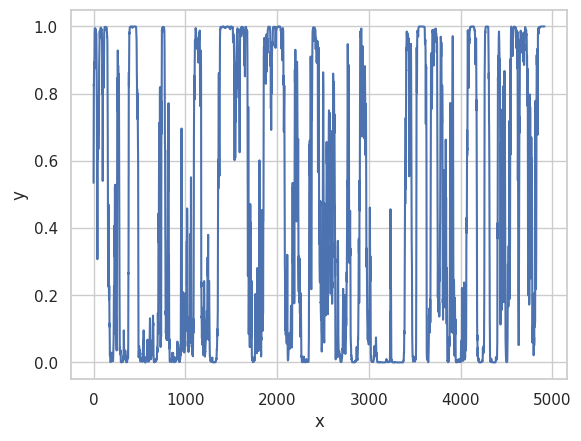

In [77]:
# Create a DataFrame
df = pd.DataFrame({'x': range(len(results_mirna)), 'y': results_mirna})
print(df.head())
# Create a relplot
sns.set_theme(style="whitegrid")
sns.lineplot(data=df, x='x', y='y')

# Show the plot
plt.show()